# Exploratory Analysis
### week_04_01_2024 update: 
store_ids = [6, 10, 11, 12, 13, 14, 15]
- (done) Explore the total revenue of each restaurant along each month - try to find patterns, growth KPIs.
- Explore patterns in payments - how many people are dividing the bill or paying total? This is only applicable to the restaurants Cantina Volpi and Ferreiro Café.
- Find new KPIs that can be of interest to the restaurant - new KPIs that can go on a monthly report.

In [115]:
import warnings
# Ignore the warning about the version of SQLAlchemy
warnings.filterwarnings('ignore', message="pandas only supports SQLAlchemy connectable.*")

### Query: Average revenue per month

In [116]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt

# Database connection parameters
db_params = {
    'dbname': 'payby_04_01',
    'user': 'postgres',
    'password': '2458',
    'host': 'localhost',
    'port': '5432'
}

def get_all_store_ids():
    query = "SELECT id FROM core_store;"
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    try:
        cur.execute(query)
        store_ids = [store[0] for store in cur.fetchall()]
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        store_ids = []
    finally:
        cur.close()
        conn.close()
    return store_ids

def get_store_name(store_id):
    query = f"SELECT name FROM core_store WHERE id = {store_id};"
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    
    try:
        cur.execute(query)
        store_name = cur.fetchone()[0]
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        store_name = None
    finally:
        cur.close()
        conn.close()
    return store_name

# Explore the total revenue of each restaurant along each month - try to find patterns, growth KPIs.
def get_confirmed_payments(store_id):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    # Modify this query to select only the relevant columns for revenue
    query = f"""
        SELECT 
            EXTRACT(MONTH FROM cp.ts_confirmed) AS month,
            EXTRACT(YEAR FROM cp.ts_confirmed) AS year,
            SUM(cp.payment_total)/100 AS revenue  -- Replace 'cp.payment_total' with your actual revenue column
        FROM "core_payment" cp
        INNER JOIN "core_ticket" ON ("cp"."ticket_id" = "core_ticket"."id") 
        INNER JOIN "core_store" ON ("core_ticket"."store_id" = "core_store"."id") 
        WHERE "core_store"."id" = {store_id}
        AND "cp"."ts_refunded" IS NULL
        AND "cp"."ts_confirmed" IS NOT NULL
        GROUP BY month, year
        ORDER BY year, month;
    """
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

def get_confirmed_payments_multi(store_id_list):
    conn = psycopg2.connect(**db_params)
    cur = conn.cursor()
    # Modify this query to select only the relevant columns for revenue
    query = f"""
        SELECT 
            EXTRACT(MONTH FROM cp.ts_confirmed) AS month,
            EXTRACT(YEAR FROM cp.ts_confirmed) AS year,
            SUM(cp.payment_total)/100 AS revenue  -- Replace 'cp.payment_total' with your actual revenue column
        FROM "core_payment" cp
        INNER JOIN "core_ticket" ON ("cp"."ticket_id" = "core_ticket"."id") 
        INNER JOIN "core_store" ON ("core_ticket"."store_id" = "core_store"."id") 
        WHERE "core_store"."id" IN ({','.join([str(store_id) for store_id in store_id_list])})
        AND "cp"."ts_refunded" IS NULL
        AND "cp"."ts_confirmed" IS NOT NULL
        GROUP BY month, year
        ORDER BY year, month;
    """
    cur.execute(query)
    results = cur.fetchall()
    cur.close()
    conn.close()
    return results

def average_revenue_per_month(results):
    total_revenue = sum([result[2] for result in results])
    if len(results) == 0: return 0
    average_revenue = total_revenue / len(results)
    return average_revenue

### Query: Top items 

In [117]:
import psycopg2
from psycopg2.extras import RealDictCursor

def get_top_items_from_db(store_id, db_params, limit=3):
    query = f"""
    WITH item_details AS (
        SELECT 
            jsonb_array_elements(items) ->> 'name' AS item_name,
            (CAST(jsonb_array_elements(items)->> 'value' AS FLOAT) * 
             CAST(jsonb_array_elements(items)->> 'amount' AS FLOAT)/100) AS item_total_value
        FROM core_ticket
        WHERE store_id = {store_id}
    )
    SELECT item_name, SUM(item_total_value) AS total_value
    FROM item_details
    GROUP BY item_name
    ORDER BY total_value DESC
    LIMIT {limit};
    """
    
    try:
        # Connect to the PostgreSQL database
        conn = psycopg2.connect(**db_params)
        cursor = conn.cursor(cursor_factory=RealDictCursor)
        
        # Execute the query
        cursor.execute(query)
        
        # Fetch the top 3 items
        top_3_items = cursor.fetchall()
        
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        top_3_items = []
        
    finally:
        if conn:
            cursor.close()
            conn.close()
            
    return top_3_items

### Query: Number of tickets per day of the week

In [118]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

# get the total number of tickets per day of the week
def get_tickets_per_day(store_id):
    query = f"""
    SELECT EXTRACT(DOW FROM ct.dt_created) AS day_of_week, COUNT(*) AS count
    FROM core_ticket ct
    INNER JOIN core_payment cp ON cp.ticket_id = ct.id
    WHERE ct.store_id = {store_id}
    AND cp.ts_refunded IS NULL
    AND cp.ts_confirmed IS NOT NULL
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def get_tickets_per_day_multi(store_id_list):
    if len(store_id_list) == 1:
        return get_tickets_per_day(store_id_list[0])
    query = f"""
    SELECT EXTRACT(DOW FROM ct.dt_created) AS day_of_week, COUNT(*) AS count
    FROM core_ticket ct
    INNER JOIN core_payment cp ON cp.ticket_id = ct.id
    WHERE ct.store_id IN {tuple(store_id_list)}
    AND cp.ts_refunded IS NULL
    AND cp.ts_confirmed IS NOT NULL
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
def get_average_ticket_size_per_day(store_id):
    query = f"""
    SELECT 
        EXTRACT(DOW FROM ct.dt_created) AS day_of_week,
        COUNT(*) AS ticket_count,
        SUM(cp.payment_total)/100 AS total_revenue 
    FROM core_ticket ct
    INNER JOIN core_payment cp ON cp.ticket_id = ct.id
    WHERE ct.store_id = {store_id}
    AND cp.ts_refunded IS NULL
    AND cp.ts_confirmed IS NOT NULL
    GROUP BY day_of_week
    ORDER BY day_of_week;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
        df['average_ticket_size'] = df['total_revenue'] / df['ticket_count']
        df['day_name'] = df['day_of_week'].map(day_names)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def plot_combined_tickets_and_average_size(df_tickets, df_avg_size, store_name, store_id):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plotting the total number of tickets
    ax1.bar(df_tickets['day_name'], df_tickets['count'], align='center', label='Total Tickets')
    ax1.set_xlabel('Day of the Week')
    ax1.set_ylabel('Number of Tickets')
    ax1.tick_params(axis='y')
    ax1.set_title(f'Total Tickets and Average Ticket Size per Day at {store_name} (store_id: {store_id})')
    
    # Second axis for the average ticket size
    ax2 = ax1.twinx() 
    ax2.plot(df_avg_size['day_name'], df_avg_size['average_ticket_size'], color='darkgreen', marker='o', label='Average Ticket Size ($)')
    ax2.set_ylabel('Average Ticket Size ($)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    plt.xticks(rotation=45)
    plt.show()

def map_day_names(df):
    day_names = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
    df['day_name'] = df['day_of_week'].apply(lambda x: day_names.get(x))
    return df

# def plot_average_ticket_size_per_day(df, store_name, store_id):
#     plt.figure(figsize=(10, 5))
#     plt.bar(df['day_name'], df['average_ticket_size'], color='lightblue')
#     plt.xlabel('Day of the Week')
#     plt.ylabel('Average Ticket Size ($)')
#     plt.title(f'Average Ticket Size per Day at {store_name} (store_id: {store_id})')
#     plt.xticks(rotation=45)
#     plt.show()


def get_best_day_to_visit(df):
    df['day_name'] = df['day_of_week'].map(day_names)
    best_day = df[df['count'] == df['count'].max()]['day_name'].values[0]
    return best_day

# def plot_tickets_per_day(df, store_name, store_id):
#     df['day_name'] = df['day_of_week'].map(day_names)
    
#     plt.figure(figsize=(10, 5))
#     plt.bar(df['day_name'], df['count'], align='center')
#     plt.xlabel('Day of the Week')
#     plt.ylabel('Number of Tickets')
#     plt.title(f'Number of tickets per day at {store_name} (store_id: {store_id})')
#     plt.xticks(rotation=45)
#     plt.show()    


### Query: Number of tickets per hour of the day

In [119]:
# print the ts_created column of the core_ticket table
def get_ticket_creation_times(store_id):
    query = f"""
    SELECT EXTRACT(HOUR FROM ct.ts_created) AS hour, COUNT(*) AS count
    FROM core_ticket ct
    INNER JOIN core_payment cp ON cp.ticket_id = ct.id
    WHERE ct.store_id = {store_id}
    AND cp.ts_refunded IS NULL
    AND cp.ts_confirmed IS NOT NULL
    GROUP BY hour
    ORDER BY hour;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def get_ticket_creation_times_multi(store_id_list):
    if len(store_id_list) == 1:
        return get_ticket_creation_times(store_id_list[0])
    query = f"""
    SELECT EXTRACT(HOUR FROM ct.ts_created) AS hour, COUNT(*) AS count
    FROM core_ticket ct
    INNER JOIN core_payment cp ON cp.ticket_id = ct.id
    WHERE ct.store_id IN {tuple(store_id_list)}
    AND cp.ts_refunded IS NULL
    AND cp.ts_confirmed IS NOT NULL
    GROUP BY hour
    ORDER BY hour;
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

def plot_tickets_per_hour(df, store_name, store_id):
    plt.figure(figsize=(10, 5))
    plt.bar(df['hour'], df['count'], align='center')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Tickets')
    plt.title(f'Number of tickets per hour at {store_name} (store_id: {store_id})')
    plt.show()


### (In-Progress) Query: Split payment 

In [120]:
for store_id in full_store_list:
    name = get_store_name(store_id)
    print(f"store_id: {store_id}, name: {name}")

intersted_store_ids = [16, 17]
def analyze_payment_patterns(store_id):
    query = f"""
    SELECT * 
    FROM core_ticket ct
    WHERE ct.store_id = {store_id}
    LIMIT 10
    """
    conn = psycopg2.connect(**db_params)
    try:
        df = pd.read_sql(query, conn)
    except psycopg2.Error as e:
        print(f"Database error: {e}")
        df = pd.DataFrame()
    finally:
        conn.close()
    return df

for store_id in intersted_store_ids:
    df = analyze_payment_patterns(store_id)
    print(df)

store_id: 1, name: payby
store_id: 6, name: ses
store_id: 8, name: Menew
store_id: 9, name: Saúde na Panela
store_id: 10, name: Shopping da Cidade
store_id: 11, name: Salvador Shopping
store_id: 12, name: Shopping Paseo Comanda
store_id: 13, name: Terraço Tancredo
store_id: 14, name: Salvador Shopping Comanda
store_id: 15, name: Shopping Paseo Mesa
store_id: 7, name: Menew Sandbox
store_id: 16, name: Cantina Volpi Ondina Mesa
store_id: 17, name: Cantina Volpi Ondina Comanda
     id ticket_pdv_id  table                       ts_created  dt_created  \
0  7099          None     25 2024-03-06 19:09:40.298760+00:00  2024-03-06   
1  7100          None     25 2024-03-06 19:14:39.928364+00:00  2024-03-06   
2  7101          None     16 2024-03-06 19:36:31.902136+00:00  2024-03-06   
3  7102          None     16 2024-03-06 19:53:38.752849+00:00  2024-03-06   
4  7285          None     10 2024-03-09 19:11:25.838518+00:00  2024-03-09   
5  7103          None     16 2024-03-06 19:55:23.077140+00:

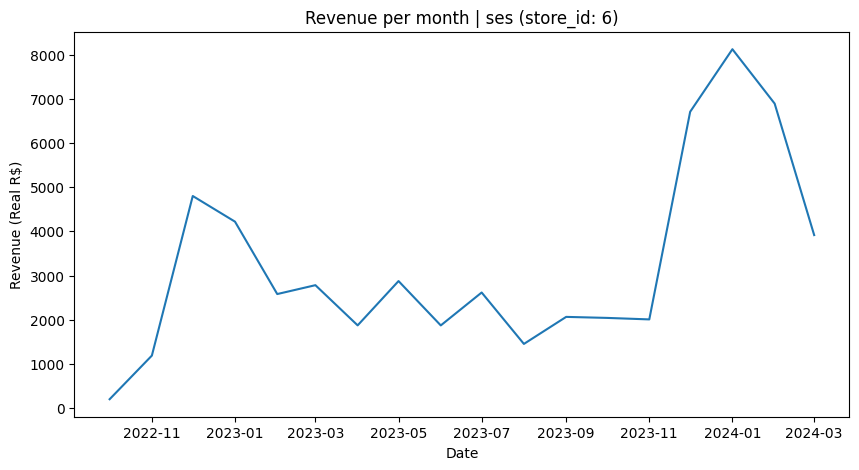

Top Items:
ALMOCO KG: $77196.10
REFRI LITRO: $2372.00
CERVEJA EISENBAHN GARRAFA: $1870.00


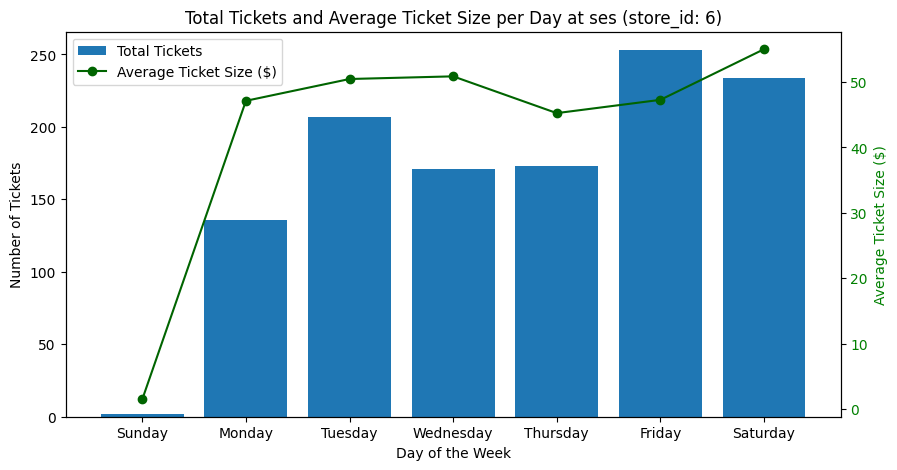

The best day to visit ses (store_id: 6) is Friday.


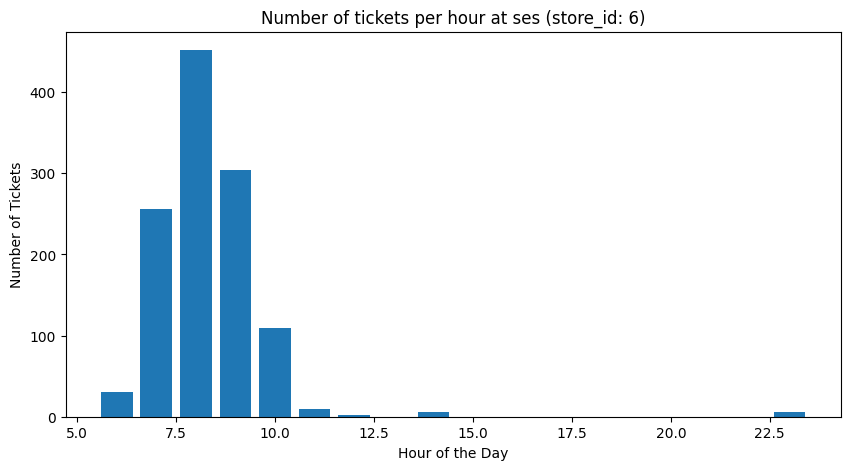

The busiest hour at ses (store_id: 6) is 8:00.
None


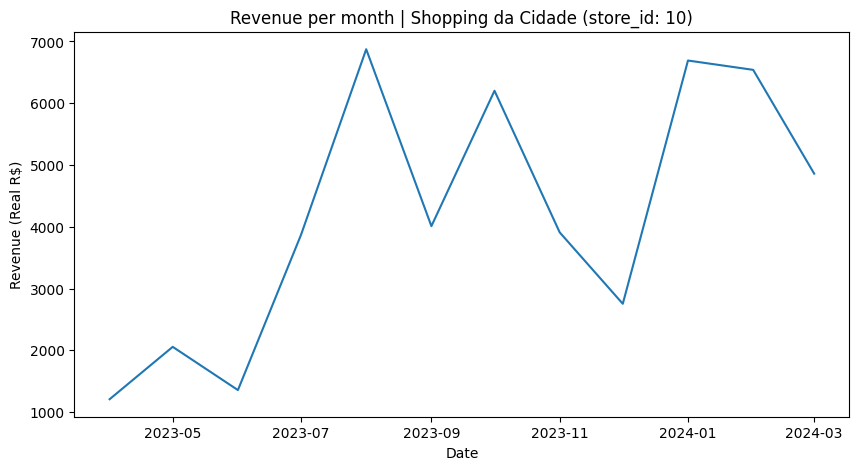

Top Items:
BUFFET C/ DESCONTO: $27449.98
BUFFET: $7090.36
SUKITA  350ML: $870.00


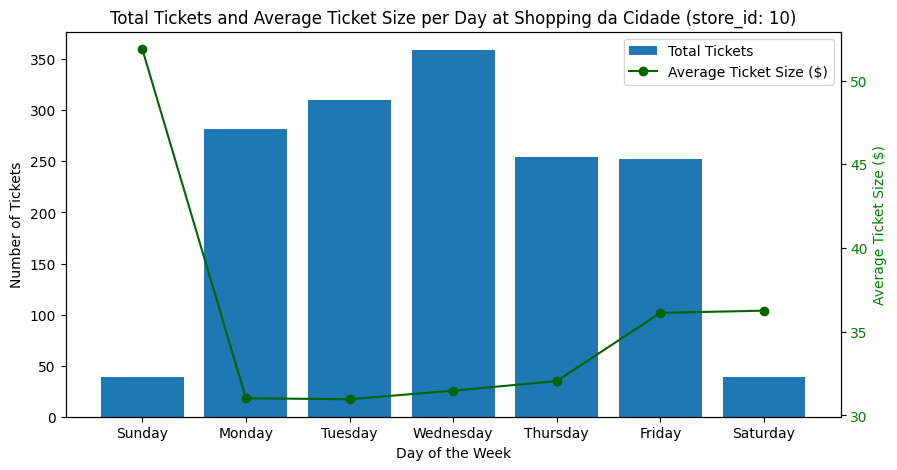

The best day to visit Shopping da Cidade (store_id: 10) is Wednesday.


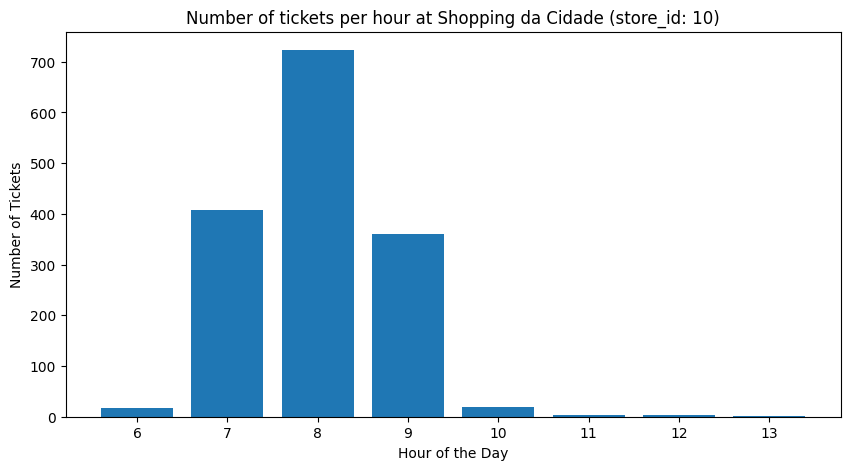

The busiest hour at Shopping da Cidade (store_id: 10) is 8:00.
None


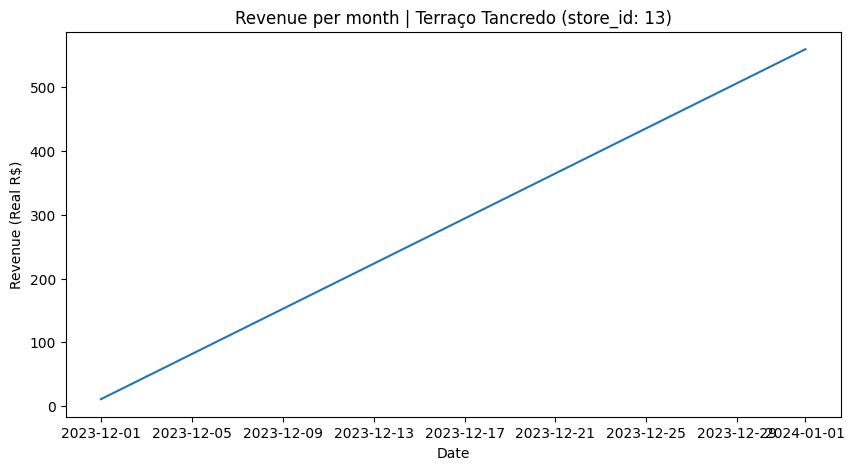

Top Items:
BUFFET: $260.34
BUFFET C/ DESCONTO: $154.92
SUCO NATURAL 300 ML: $24.00


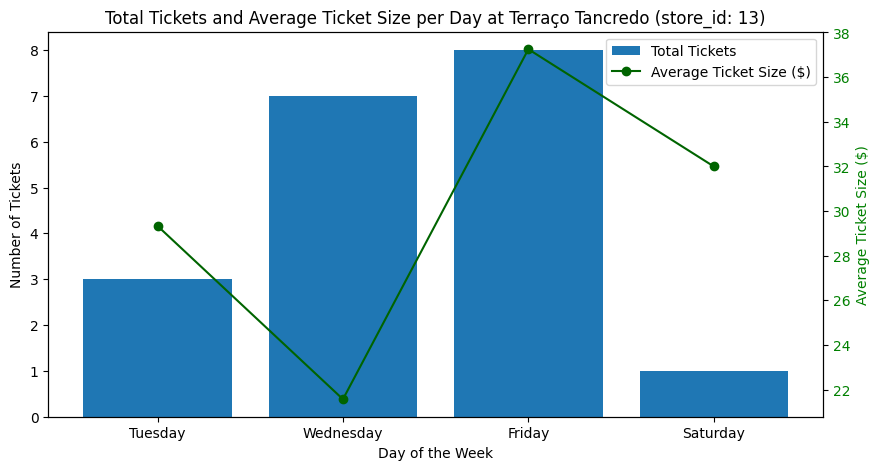

The best day to visit Terraço Tancredo (store_id: 13) is Friday.


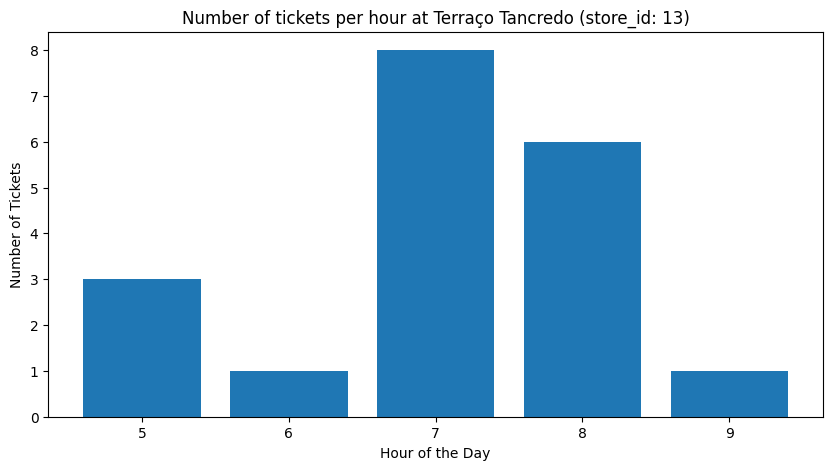

The busiest hour at Terraço Tancredo (store_id: 13) is 7:00.
None


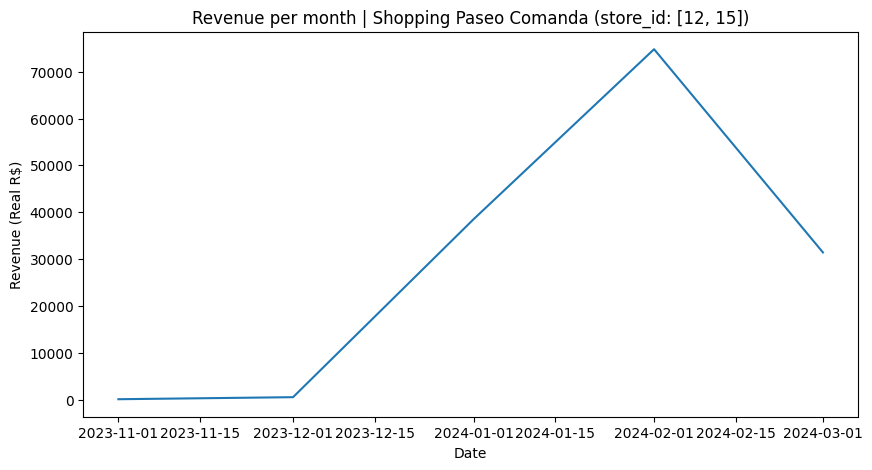

Top Items:
BUFFET: $260.34
BUFFET C/ DESCONTO: $154.92
SUCO NATURAL 300 ML: $24.00


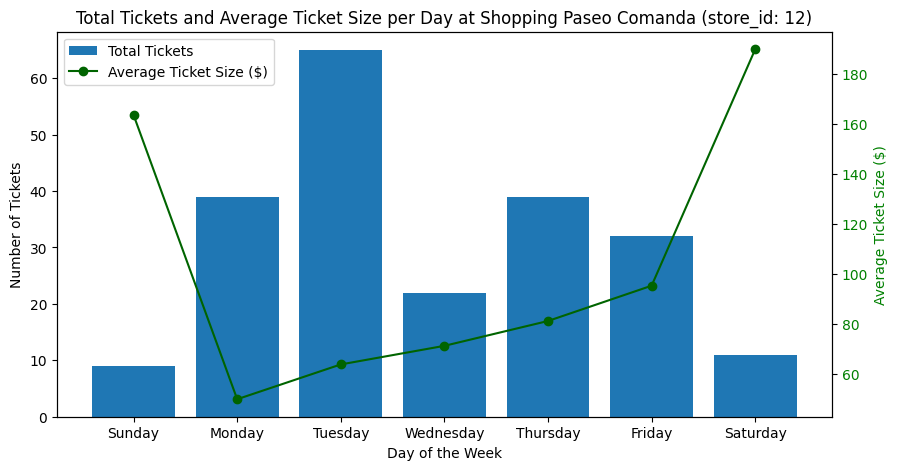

The best day to visit Shopping Paseo Comanda (store_id: 12) is Tuesday.


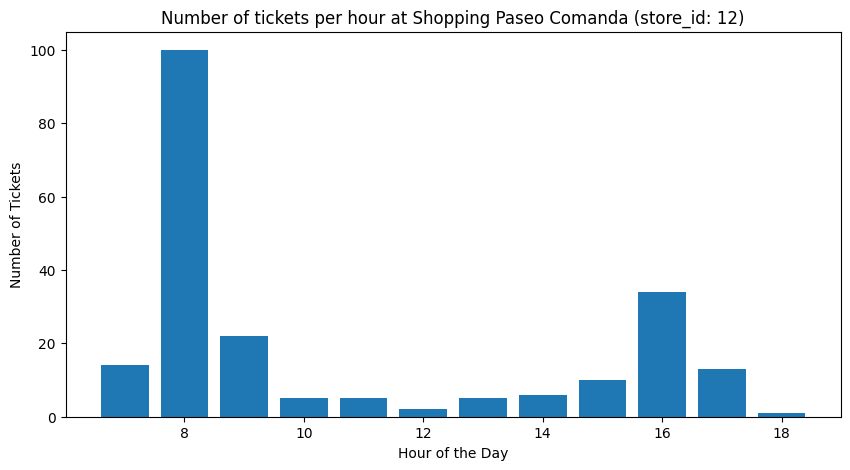

The busiest hour at Shopping Paseo Comanda (store_id: 12) is 8:00.
None


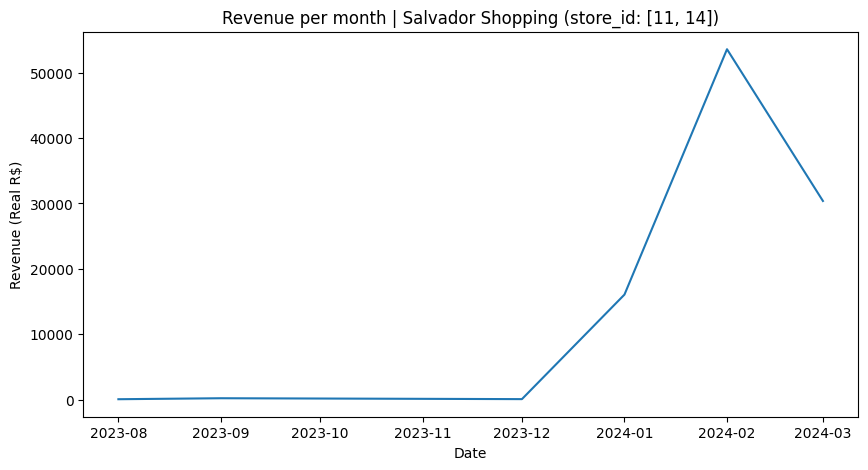

Top Items:
BUFFET: $260.34
BUFFET C/ DESCONTO: $154.92
SUCO NATURAL 300 ML: $24.00


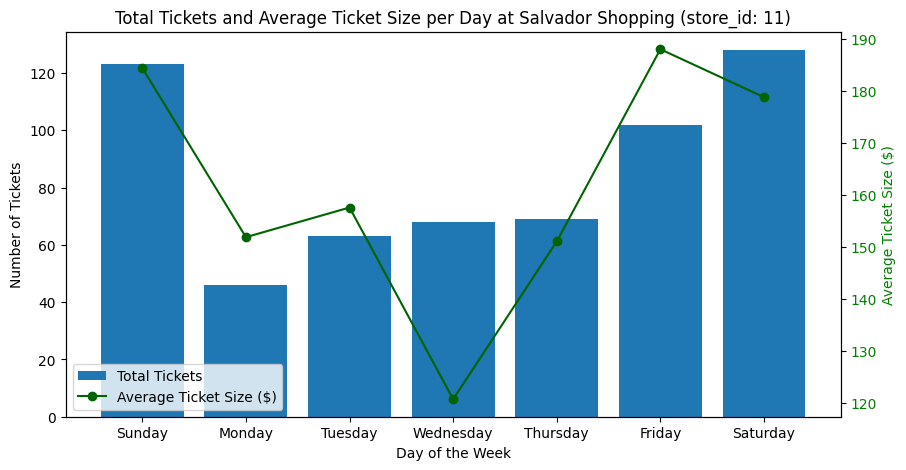

The best day to visit Salvador Shopping (store_id: 11) is Saturday.


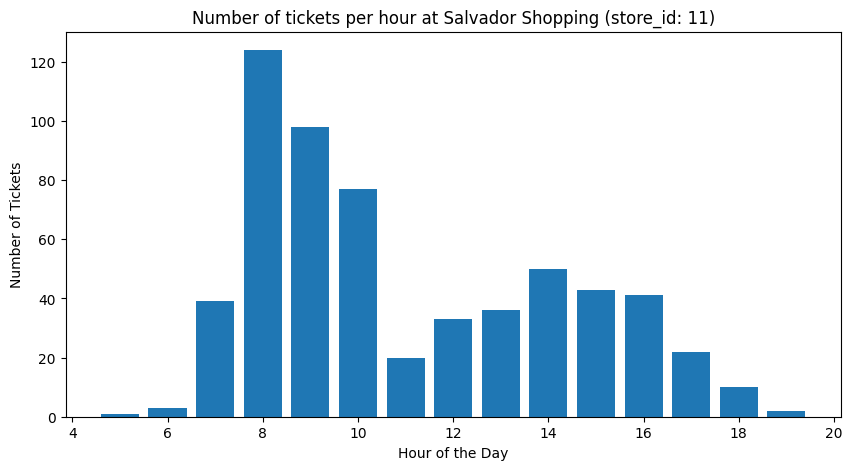

The busiest hour at Salvador Shopping (store_id: 11) is 8:00.
None


In [121]:
def plot_revenue(store_id, store_name, plot=True):
    if plot:
        revenue = get_confirmed_payments(store_id)
        df = pd.DataFrame(revenue, columns=['month', 'year', 'revenue'])
        df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
        df = df.sort_values('date')
        plt.figure(figsize=(10, 5))
        plt.xlabel('Date')
        plt.ylabel('Revenue (Real R$)')
        plt.title(f"Revenue per month | {store_name} (store_id: {store_id})")
        plt.plot(df['date'], df['revenue'])
        plt.show()

def plot_combined_revenue(store_id_list, store_name, plot=True):
    if plot:
        revenue = get_confirmed_payments_multi(store_id_list)
        df = pd.DataFrame(revenue, columns=['month', 'year', 'revenue'])
        df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
        df = df.sort_values('date')
        plt.figure(figsize=(10, 5))
        plt.xlabel('Date')
        plt.ylabel('Revenue (Real R$)')
        plt.title(f"Revenue per month | {store_name} (store_id: {store_id_list})")
        plt.plot(df['date'], df['revenue'])
        plt.show()

def evaluate_best_day_and_hour(store_id, store_name, plot=True):
    df_tickets_day = get_tickets_per_day(store_id)
    df_avg_ticket_size = get_average_ticket_size_per_day(store_id)  # Get the average ticket size data
    if not df_tickets_day.empty:
        best_day = get_best_day_to_visit(df_tickets_day)
        if plot:
            # Ensure day names are mapped for both dataframes
            df_tickets_day = map_day_names(df_tickets_day)
            df_avg_ticket_size = map_day_names(df_avg_ticket_size)
            # Plot combined chart of tickets and average ticket size
            plot_combined_tickets_and_average_size(df_tickets_day, df_avg_ticket_size, store_name, store_id)
        print(f"The best day to visit {store_name} (store_id: {store_id}) is {best_day}.")
    else:
        print(f"No tickets found for store_id: {store_id}.")

    df_tickets_hour = get_ticket_creation_times(store_id)
    if not df_tickets_hour.empty:
        busiest_hour = df_tickets_hour[df_tickets_hour['count'] == df_tickets_hour['count'].max()]['hour'].values[0]
        if plot:
            plot_tickets_per_hour(df_tickets_hour, store_name, store_id)
        print(f"The busiest hour at {store_name} (store_id: {store_id}) is {int(busiest_hour)}:00.")
    else:
        print(f"No tickets found for store_id: {store_id}.")


def print_top_items(store_id):
    # Get the top items from the database
    top_items = get_top_items_from_db(store_id, db_params)
    
    # Format and print the top items
    if top_items:
        item_descriptions = []
        for item in top_items:
            description = f"{item['item_name']}: ${item['total_value']:.2f}"
            item_descriptions.append(description)
        
        return "Top Items:\n" + "\n".join(item_descriptions)
    else:
        return "No top items found for store_id: {}".format(store_id)
    
plot_data = True  # Control variable for plotting

full_store_list = get_all_store_ids()

# Store IDs to explore
store_ids = [6, 10, 13]
store_ids_comb = [[12, 15], [11, 14]]

# Individual store IDs
for store_id in store_ids:
    if store_id not in full_store_list:
        print(f"store_id {store_id} not found")
        continue
    
    store_name = get_store_name(store_id)
    if plot_data:
        plot_revenue(store_id, store_name, plot=True)
    print(print_top_items(store_id))
    print(evaluate_best_day_and_hour(store_id, store_name, plot=plot_data))

# Combined store IDs
for store_id_list in store_ids_comb:
    store_name = get_store_name(store_id_list[0])
    if plot_data:
        plot_combined_revenue(store_id_list, store_name, plot=True)
    print(print_top_items(store_id))
    print(evaluate_best_day_and_hour(store_id_list[0], store_name, plot=plot_data))
